In [1]:
import SimpleITK as sitk
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import cv2
from pathlib import Path

(324, 546, 417)


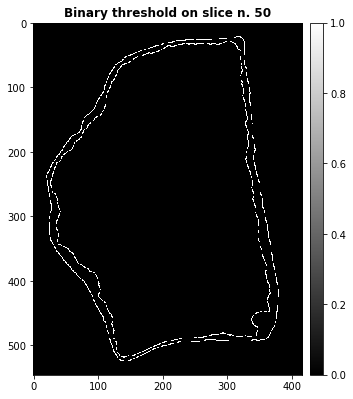

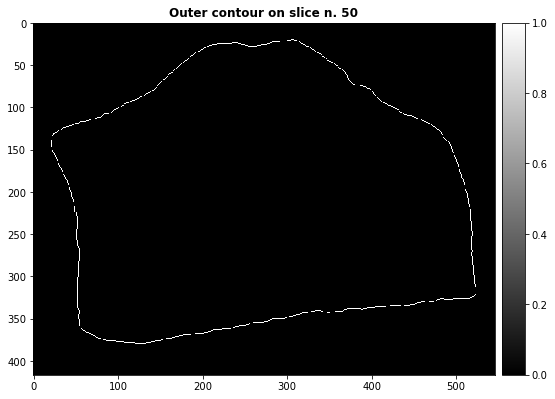

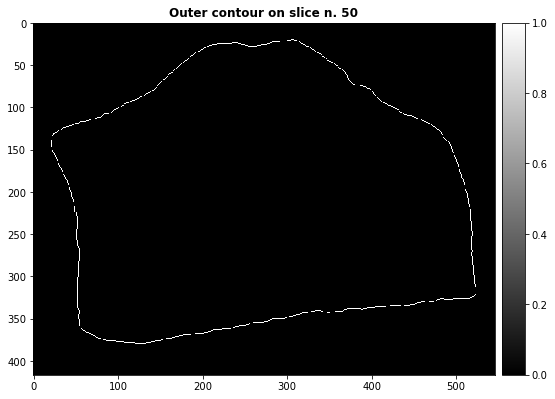

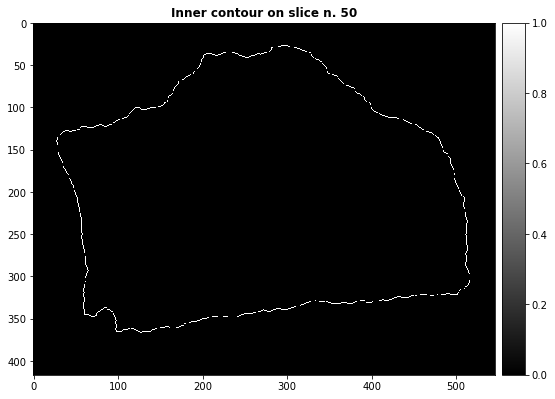

(<SimpleITK.SimpleITK.Image; proxy of <Swig Object of type 'std::vector< itk::simple::Image >::value_type *' at 0x7fce42264e70> >,
 <SimpleITK.SimpleITK.Image; proxy of <Swig Object of type 'std::vector< itk::simple::Image >::value_type *' at 0x7fce42274960> >,
 array([[ 0.        ,  0.03601978,  0.07203956, ..., 19.55874044,
         19.59476022, 19.63078   ],
        [ 0.        ,  0.03601978,  0.07203956, ..., 19.55874044,
         19.59476022, 19.63078   ],
        [ 0.        ,  0.03601978,  0.07203956, ..., 19.55874044,
         19.59476022, 19.63078   ],
        ...,
        [ 0.        ,  0.03601978,  0.07203956, ..., 19.55874044,
         19.59476022, 19.63078   ],
        [ 0.        ,  0.03601978,  0.07203956, ..., 19.55874044,
         19.59476022, 19.63078   ],
        [ 0.        ,  0.03601978,  0.07203956, ..., 19.55874044,
         19.59476022, 19.63078   ]]),
 array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [

In [2]:
# fmt: off

def plot_slice(image, SLICE, title, ASPECT):
    plt.figure("Binary contour", figsize=(np.shape(sitk.GetArrayFromImage(image))[1] / ASPECT, np.shape(sitk.GetArrayFromImage(image))[2] / ASPECT))
    plt.imshow(sitk.GetArrayViewFromImage(image)[:, :, SLICE], cmap="gray", interpolation="None", aspect="equal")
    plt.title(title, weight="bold")
    ax = plt.gca()
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.1)
    plt.colorbar(cax=cax)
    plt.show()

def exec_thresholding(image, THRESHOLD_PARAM):
    # Binary threshold
    btif = sitk.BinaryThresholdImageFilter()
    btif.SetInsideValue(THRESHOLD_PARAM[0])
    btif.SetOutsideValue(THRESHOLD_PARAM[1])
    btif.SetLowerThreshold(THRESHOLD_PARAM[2])
    btif.SetUpperThreshold(THRESHOLD_PARAM[3])
    image_thr = btif.Execute(image)
    return image_thr

def draw_contours(img, loc=str('outer')):
    '''
    https://stackoverflow.com/questions/25733694/process-image-to-find-external-contour
    '''
    if loc == 'outer':
        _contours, hierarchy = cv2.findContours(img.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        out = np.empty(np.shape(img))
        contour = cv2.drawContours(out, _contours, -1, 1, 1)  # all contours, in white, with thickness 1
    elif loc == 'inner':
        _contours, hierarchy = cv2.findContours(img.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
        inn = np.empty(np.shape(img))
        contour = cv2.drawContours(inn, _contours, 2, 1, 1)
    else:
        raise ValueError("The location of the contour is not valid. Please choose between 'outer' and 'inner'.")
    return contour

def get_binary_contour(image):
    # https://itk.org/pipermail/community/2017-August/013464.html
    img_thr_join = sitk.JoinSeries([sitk.BinaryContour(image[z, :, :], fullyConnected=True) for z in range(image.GetSize()[0])])
    img_thr_join = sitk.PermuteAxes(img_thr_join, [2, 1, 0])
    img_thr_join.SetSpacing(image.GetSpacing())
    return img_thr_join

def get_draw_contour(image, loc=str('outer')):
    img_np = np.transpose(sitk.GetArrayFromImage(image), [2, 1, 0])
    outer_contour = np.empty((np.shape(img_np)[0], np.shape(img_np)[1], np.shape(img_np)[2]), dtype=np.uint8)
    outer_contour = [draw_contours(img_np[z, :, :], loc) for z in np.arange(np.shape(img_np)[0])]
    outer_contour_np = np.array(outer_contour)
    outer_contour_np = np.transpose(outer_contour_np, [1, 2, 0])
    outer_contour_np = np.flip(outer_contour_np, axis=1)
    return outer_contour_np

def binary_threshold(img_path, show_plots=False, phases=2):
        """
        THRESHOLD_PARAM = [INSIDE_VAL, OUTSIDE_VAL, LOWER_THRESH, UPPER_THRESH]
        """
        THRESHOLD_PARAM = [0, 1, 0, 0.9]
        ASPECT = 50
        SLICE = 50

        image = sitk.ReadImage(img_path)
        print(image.GetSize())
        image_thr = exec_thresholding(image, THRESHOLD_PARAM)
        img_thr_join = get_binary_contour(image_thr)

        if show_plots is not False:
            plot_slice(img_thr_join, SLICE, f"Binary threshold on slice n. {SLICE}", ASPECT)
        else:
            print(f"Binary threshold, show_plots:\t{show_plots}")

        if phases >= 1:
            outer_contour_np = get_draw_contour(img_thr_join)
            outer_contour_sitk = sitk.GetImageFromArray(outer_contour_np)
            outer_contour_sitk.CopyInformation(image)

            if show_plots is not False:
                plot_slice(outer_contour_sitk, SLICE, f"Outer contour on slice n. {SLICE}", ASPECT)
            else:
                print(f"Binary threshold, show_plots:\t{show_plots}")

        if phases == 2:
            outer_contour_np = get_draw_contour(img_thr_join, loc='outer')
            outer_contour_sitk = sitk.GetImageFromArray(outer_contour_np)
            outer_contour_sitk.CopyInformation(image)
            
            inner_contour_np = get_draw_contour(img_thr_join, loc='inner')
            inner_contour_sitk = sitk.GetImageFromArray(inner_contour_np)
            inner_contour_sitk.CopyInformation(image)

            if show_plots is not False:
                plot_slice(outer_contour_sitk, SLICE, f"Outer contour on slice n. {SLICE}", ASPECT)
            else:
                print(f"Binary threshold, show_plots:\t{show_plots}")

            if show_plots is not False:
                # plot_slice(outer_contour_sitk, SLICE, f"Outer contour on slice n. {SLICE}", ASPECT)
                plot_slice(inner_contour_sitk, SLICE, f"Inner contour on slice n. {SLICE}", ASPECT)
            else:
                print(f"Binary threshold, show_plots:\t{show_plots}")

        if phases > 2:
            raise ValueError("The number of phases is greater than 2. Only biphasic materials are accepted (e.g. cort+trab).")

        img_size = image.GetSize()
        img_spacing = image.GetSpacing()

        coordsX = np.arange(0, img_size[0] * img_spacing[0], img_size[0] * img_spacing[0] / float(image.GetSize()[1]))
        coordsY = np.arange(0, img_size[1] * img_spacing[1], img_size[1] * img_spacing[1] / float(image.GetSize()[2]))
        coordsX, coordsY = np.meshgrid(coordsX, coordsY)

        if phases == 1:
            return outer_contour_sitk, coordsX, coordsY
        if phases == 2:
            return outer_contour_sitk, inner_contour_sitk, coordsX, coordsY
    
img_basefilename =  "C0002234"
img_basepath = r"/home/simoneponcioni/Documents/01_PHD/03_Methods/Meshing/Meshing/01_AIM"
img_path_t = str(Path(img_basepath, img_basefilename, img_basefilename + "_CORT_MASK_cap.mhd",))
binary_threshold(img_path=img_path_t, show_plots=True, phases=2)

# fmt: on